pytorch CNN構築

In [ ]:
import numpy as np
import torch
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import datasets,transforms,utils

データセットを準備する

MNISTデータセットの紹介がhttps://www.atmarkit.co.jp/ait/articles/2001/22/news012.html

このサイトを参考してください

#transfroms
Composeは複数データ処理手法持っています

ToTensor Tensorーー＞https://ja.wikipedia.org/wiki/%E3%83%86%E3%83%B3%E3%82%BD%E3%83%AB

データを正規化する

Normalized_image =(image-mean)/std
RGBの場合「0.5,0.5,0.5」

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],std=[0.5])])

root:path

train: True -->訓練データ
      　Flase－－＞テストデータ

transform:データ処理手法

In [ ]:
train_data = datasets.MNIST(root = "./data/",
                            transform=transform,
                            train = True,
                            download = True)

test_data = datasets.MNIST(root = "./data/",
                            transform=transform,
                            train = False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


batch_size 説明：https://qiita.com/kenta1984/items/bad75a37d552510e4682

train_loaderの長さは60000/64=938 batch

test_loader 10000/64=157batch

In [ ]:
print(len(train_data))
len(test_data)

60000


10000

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True,num_workers=4)

test_loader = torch.utils.data.DataLoader(test_data,batch_size=64,shuffle=True,num_workers=4)

<function matplotlib.pyplot.show>

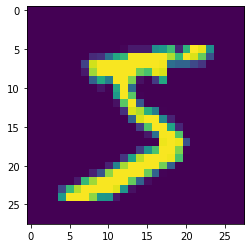

In [ ]:
one_img,label = train_data[0]
one_img = one_img.numpy().transpose(1,2,0)
std=[0.5]
mean=[0.5]
one_img = one_img *std +mean

one_img.resize(28,28)
plt.imshow(one_img)
plt.show

tensor(3) tensor(4) tensor(8) tensor(3) tensor(1) tensor(3) tensor(2) tensor(1) 
tensor(6) tensor(9) tensor(5) tensor(5) tensor(7) tensor(8) tensor(6) tensor(4) 
tensor(3) tensor(0) tensor(2) tensor(0) tensor(3) tensor(7) tensor(2) tensor(8) 
tensor(9) tensor(4) tensor(2) tensor(2) tensor(8) tensor(0) tensor(1) tensor(0) 
tensor(5) tensor(5) tensor(7) tensor(5) tensor(7) tensor(9) tensor(2) tensor(5) 
tensor(8) tensor(6) tensor(4) tensor(3) tensor(4) tensor(4) tensor(8) tensor(6) 
tensor(5) tensor(0) tensor(5) tensor(9) tensor(0) tensor(6) tensor(5) tensor(2) 
tensor(5) tensor(4) tensor(5) tensor(3) tensor(4) tensor(2) tensor(2) tensor(9) 


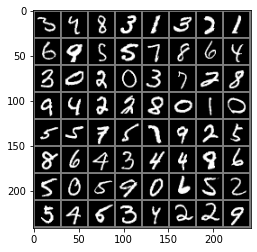

In [ ]:
#output one batch img and lables
images, lables = next(iter(train_loader))
img = utils.make_grid(images)

img = img.numpy().transpose(1,2,0) 
std = [0.5]
mean = [0.5]
img = img * std + mean
for i in range(64):
    print(lables[i], end=" ")
    i += 1
    if i%8 is 0:
        print(end='\n')
plt.imshow(img)
plt.show()

#ニューラルネットワーク

今回２つ畳み込み層と３つのfully connected layers

##Conv2dパラメータ

* in_channels(int) 
* out_channels(int) 
* kerner_size(int or tuple) 
* stride(int or tuple, optional) 
* padding(int or tuple, optional)


In [ ]:
import torch.nn.functional as F
class CNN(nn.Module):
  def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        
        #fully connected layers
        self.fc1 = nn.Linear(64*7*7,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,10)

        #dropout
        self.dp = nn.Dropout(p=0.5)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))

    x = x.view(-1,64*7*7)#一次元に収縮する
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    self.dp(x)
    x = self.fc3(x)

    return x

net = CNN()

loss function

Optimized function

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#or Adam
#optimizer = torch.optim.Adam(net.parameters(),lr=1e-2)

train model  
 

data format[inputs,labels]

In [ ]:
train_accs = []
train_loss = []
test_accs = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

for epoch in range(5):
  running_loss = 0.0
  for i,data in enumerate(train_loader,0):
    #0-->label start station
    inputs,labels = data[0].to(device),data[1].to(device)
    #Clear the gradient of the last batch
    optimizer.zero_grad()

    #forward backward 
    outputs = net(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    #optimizer
    optimizer.step()

    running_loss += loss.item()
    if i%100 == 99:
      print(('[%d,%5d] loss :%.3f' %
            (epoch+1,i+1,running_loss/100)))
      running_loss = 0.0
    train_loss.append(loss.item())

    correct = 0
    total = 0
    #torch.max return-->(Tensor,LongTensor)
    _, predicted = torch.max(outputs.data, dim = 1)
    
    total = labels.size(0)
    # Predict the correct number
    correct = (predicted == labels).sum().item() 
    train_accs.append(100*correct/total)   

print('Finished Training')

[1,  100] loss :0.269
[1,  200] loss :0.262
[1,  300] loss :0.248
[1,  400] loss :0.222
[1,  500] loss :0.226
[1,  600] loss :0.200
[1,  700] loss :0.199
[1,  800] loss :0.180
[1,  900] loss :0.177
[2,  100] loss :0.160
[2,  200] loss :0.144
[2,  300] loss :0.133
[2,  400] loss :0.131
[2,  500] loss :0.140
[2,  600] loss :0.127
[2,  700] loss :0.135
[2,  800] loss :0.120
[2,  900] loss :0.112
[3,  100] loss :0.102
[3,  200] loss :0.101
[3,  300] loss :0.105
[3,  400] loss :0.103
[3,  500] loss :0.096
[3,  600] loss :0.094
[3,  700] loss :0.098
[3,  800] loss :0.099
[3,  900] loss :0.091
[4,  100] loss :0.090
[4,  200] loss :0.080
[4,  300] loss :0.083
[4,  400] loss :0.088
[4,  500] loss :0.076
[4,  600] loss :0.076
[4,  700] loss :0.079
[4,  800] loss :0.083
[4,  900] loss :0.076
[5,  100] loss :0.073
[5,  200] loss :0.071
[5,  300] loss :0.063
[5,  400] loss :0.069
[5,  500] loss :0.070
[5,  600] loss :0.075
[5,  700] loss :0.067
[5,  800] loss :0.069
[5,  900] loss :0.070
Finished T

In [ ]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

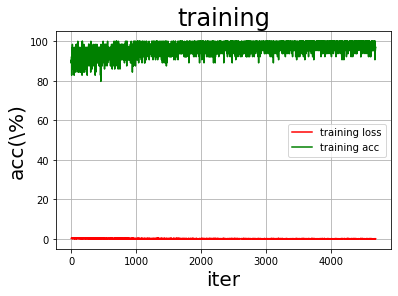

In [ ]:
def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("acc(\%)", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()
train_iters = range(len(train_accs))
draw_train_process('training',train_iters,train_loss,train_accs,'training loss','training acc')

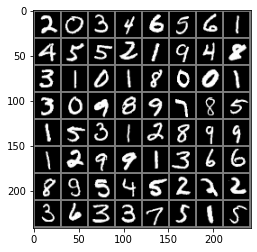

GroundTruth:  2 0 3 4 6 5 6 1 4 5 5 2 1 9 4 8 3 1 0 1 8 0 0 1 3 0 9 8 9 7 8 5 1 5 3 1 2 8 9 9 1 2 9 9 1 3 6 6 8 9 5 4 5 2 2 2 3 6 3 3 7 5 1 5


In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
test_img = utils.make_grid(images)
test_img = test_img.numpy().transpose(1,2,0)
std = [0.5,0.5,0.5]
mean =  [0.5,0.5,0.5]
test_img = test_img*std+0.5
plt.imshow(test_img)
plt.show()
print('GroundTruth: ', ' '.join('%d' % labels[j] for j in range(64)))

In [ ]:
test_net = CNN()
test_net.load_state_dict(torch.load(PATH))
test_out = test_net(images) 

_, predicted = torch.max(test_out, dim=1)
print('Predicted: ', ' '.join('%d' % predicted[j]
                              for j in range(64)))

Predicted:  2 0 3 4 6 5 6 1 4 5 5 2 1 9 4 8 3 1 0 1 8 0 0 1 3 0 9 8 9 7 8 5 1 5 0 1 2 8 9 9 1 2 9 9 1 3 6 6 8 9 5 4 5 2 2 2 3 6 3 3 7 5 1 5


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in test_loader:
    images,labels = data
    outputs = test_net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels)
    for i in range(10):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1


In [ ]:
for i in range(10):
    print('Accuracy of %d : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

Accuracy of 0 : 100 %
Accuracy of 1 : 100 %
Accuracy of 2 : 96 %
Accuracy of 3 : 99 %
Accuracy of 4 : 98 %
Accuracy of 5 : 99 %
Accuracy of 6 : 97 %
Accuracy of 7 : 94 %
Accuracy of 8 : 96 %
Accuracy of 9 : 94 %
